In [177]:
import numpy as np
import pandas as pd
from scipy.stats import mode
from collections import deque

In [171]:

class EarlyStopping:
    def __init__(self, patience):
        self.patience = patience
        self.values = deque(maxlen = self.patience)
        self.current_best = None
        self.current_min = np.inf
        
    def should_break(self, value):
        self.current_min = min(self.current_min, value)
        self.values.append(value)
        if len(self.values) == self.patience and ((np.array(self.values) >= self.current_min) == True).all():
            return True
        
        return False

class KClustering:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.centroids = None
        self.clusters = {i:None for i in range(0,self.n_clusters)}
        self.store_iterations = {}
        self._cost = None

    
    def setUp(self, X):  
        self.X = X
        self.N, self.p = self.X.shape
        self.ind = np.arange(self.N)

        
    def _init_centroids_and_clusters(self, how = 'random'):
        if how == 'random':
            centroids = self.X[np.random.choice(np.arange(self.N),(self.n_clusters))]
            clusters = {i:None for i in range(0,self.n_clusters)}
            return centroids, clusters
        else:
            raise NotImplementedError
            
    def _distance_metric(self, x1, x2, axis):
        pass
    
    def _get_centroid(self, data):
        pass
    
    def _cost_func(self, centroids, clusters):
        res = []
        for i in range(0,self.n_clusters):
            costs = [self._distance_metric(x, centroids[i],0) for x in self.X[clusters[i]]]
            if len(costs) == 0:
                continue
            mean_costs = np.mean(costs)
            res.append(mean_costs)
        return np.array(res)
        
    def _current_fits(self, centroids, clusters, cost, i):
        self.store_iterations[i] = {}
        self.store_iterations[i]['centroids'] = centroids
        self.store_iterations[i]['clusters'] = clusters
        self.store_iterations[i]['cost'] = cost
        
    def _do_iteration(self, centroids, clusters):
        dist = np.array([self._distance_metric(x, centroids, 1) for x in self.X])
            
        for j in range(0,self.n_clusters):
            clusters[j] = self.ind[np.argmin(dist,1) == j]
                
        for i,val in enumerate(list(clusters.values())):
            if len(val) != 0:
                centroids[i] = self._get_centroid(self.X[val])#mode(self.X[val],0).mode[0]
        
        return centroids, clusters
        
        
    def _fit(self, max_iter = 200, verbose = True, patience = 10):
        es = EarlyStopping(patience = patience)
   
        centroids, clusters = self._init_centroids_and_clusters()
        
        for i in range(0,max_iter):
            
            centroids, clusters = self._do_iteration(centroids, clusters)
            if es.should_break(np.mean(self._cost_func(centroids, clusters))):
                break
            
        return centroids, clusters, self._cost_func(centroids, clusters)
    
    def fit(self, X,max_iter = 200, verbose = True, n_fit = 5):

        self.setUp(X)
        current_minimum_loss = np.inf
        
        for i in range(0,n_fit):
            centroids, clusters, loss_per_cluster = self._fit()
            if 0 in list(map(len,clusters.values())):
                self._current_fits([], [], np.inf, i)
                continue
            loss = np.mean(loss_per_cluster)
            self._current_fits(centroids, clusters, loss, i)

            if loss <= current_minimum_loss:
                self.centroids = centroids
                self.clusters = clusters
                self._cost = loss
                
                current_minimum_loss = loss
                
                
class KModes(KClustering):
    def __init__(self, n_clusters):
        super().__init__(n_clusters)
        
    def _distance_metric(self, x1, x2, axis):
        # implementing the hamming distance here
        x1,x2 = np.array(x1), np.array(x2)
        return np.sum(x1!=x2, axis)
        
    def _get_centroid(self, data):
        return mode(data,0).mode[0]
    
class KMeans(KClustering):
    def __init__(self, n_clusters):
        super().__init__(n_clusters)
        
    def _distance_metric(self, x1, x2, axis):
        diff = x1 - x2
        return np.sqrt(np.sum(diff**2,axis))
        
    def _get_centroid(self, data):
        return np.mean(data,0)
    
    
class KPrototypes:
    def __init__(self, n_clusters, gamma, categorical_indices, numerical_indices):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.categorical_indices = categorical_indices
        self.numerical_indices = numerical_indices
        
        self.kmodes = None
        self.kmeans = None
        
        self.clusters = None
        self.modes = None
        self.means = None
        self._cost = None
        
        self.store_iterations  = {}
        
    def setUp(self, X):  
        self.X = X
        self.N, self.p = self.X.shape
        self.ind = np.arange(self.N)
        self.kmodes = KModes(self.n_clusters)
        self.kmeans = KMeans(self.n_clusters)
        self.kmodes.setUp(self.X[:, self.categorical_indices])
        self.kmeans.setUp(self.X[:, self.numerical_indices])
        
    def _current_fits(self, modes ,means, clusters, cost, i):
        self.store_iterations[i] = {}
        self.store_iterations[i]['modes'] = modes
        self.store_iterations[i]['means'] = means
        self.store_iterations[i]['clusters'] = clusters
        self.store_iterations[i]['cost'] = cost
        
    def _cost_func(self, centroids_means, centroids_modes, clusters):
        loss = np.mean(self.kmeans._cost_func(centroids_means, clusters)) \
        + self.gamma*np.mean(self.kmodes._cost_func(centroids_modes, clusters))
        return loss
    
    def _fit(self, X, max_iter = 200, patience = 10):
        es = EarlyStopping(patience = patience)
        centroids_modes, clusters = model_modes._init_centroids_and_clusters()
        centroids_means, _ = model_means._init_centroids_and_clusters()
        
        for i in range(0, max_iter):
            centroids_modes, clusters = model_modes._do_iteration(centroids_modes, clusters)
            centroids_means,clusters = model_means._do_iteration(centroids_means,clusters)
            
            if es.should_break(np.mean(self._cost_func(centroids_means, centroids_modes, clusters))):
                break
            
        return centroids_modes, centroids_means, clusters, \
            self._cost_func(centroids_means, centroids_modes, clusters)
        
    def fit(self, X, max_iter = 200, n_fits = 5):
        self.setUp(X)
        
        current_minimum_loss = np.inf
        
        for i in range(0,n_fits):
            modes, means, clusters, loss = self._fit(X)
            self._current_fits(modes ,means, clusters, loss, i)
            
            current_minimum_loss = min(current_minimum_loss, loss)
            if loss <= current_minimum_loss:
                self.modes = modes
                self.means = means
                self.clusters = clusters
                self._cost = loss
                
                current_minimum_loss = loss
            
        #return modes, means, clusters, loss

In [172]:
X = np.array([[1,1,1,0,0,0,0,0,0] for i in range(50)] + [[0,0,0,1,1,1,0,0,0] for i in range(50)] + \
[[0,0,0,0,0,0,1,1,1,] for i in range(50)])
model = KModes(3)
model.fit(X)
print(model.centroids)
print(model.clusters)

[[0 0 0 1 1 1 0 0 0]
 [1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1]]
{0: array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), 2: array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149])}


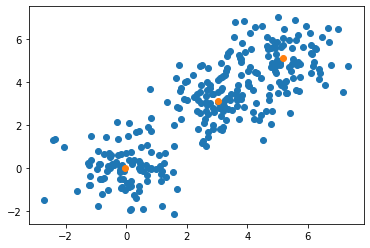

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

X1 = np.random.normal(0,1,(100,2))
X2 = np.random.normal(3,1,(100,2))
X3 = np.random.normal(5,1,(100,2))


Z = np.concatenate([X1,X2,X3])
model = kmeans(3)
model.fit(Z)

plt.scatter(Z.T[0],Z.T[1])
plt.scatter(model.centroids.T[0],model.centroids.T[1])

In [176]:
X_categorical = np.array([[1,1,1,0,0,0,0,0,0] for i in range(50)] + [[0,0,0,1,1,1,0,0,0] for i in range(50)] + \
[[0,0,0,0,0,0,1,1,1,] for i in range(50)])

X1 = np.random.normal(0,1,(50,2))
X2 = np.random.normal(3,1,(50,2))
X3 = np.random.normal(5,1,(50,2))

X_numerical = np.concatenate([X1,X2,X3])
X = np.concatenate([X_categorical, X_numerical],1)


X_categorical_ind = [0,1,2,3,4,5,6,7,8]
X_numerical_ind = [9,10]
model = KPrototypes(3,1,X_categorical_ind,X_numerical_ind)
model.fit(X)
print(model.modes)
print(model.means)
print(model.clusters)

[[0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0.]]
[[ 4.83175807  5.23137014]
 [ 3.22304689  2.81735992]
 [ 0.29094831 -0.2104882 ]]
{0: array([ 50,  51,  58,  65,  71,  84,  92,  98, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149]), 1: array([ 52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  64,  66,
        67,  68,  70,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  85,  86,  87,  88,  89,  90,  91,  93,  94,  95,  96,
        97,  99, 126]), 2: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 69])}
